In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.0MB/s 
     |████████████████████████████████| 194kB 22.9MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 1.0MB 15.9MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 40kB 7.0MB/s 
     |████████████████████████████████| 92kB 11.5MB/s 
     |████████████████████████████████| 40kB 7.5MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 2.6MB 30.2MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '0269a202ba68419e963fced4a3553e0c')

In [4]:
# Using the Bing Image Search API to for grizzly bear images and stores as fastcore's L (similiar to NumPy array)
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

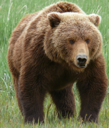

In [7]:
# Testing to see if images can be downloaded and displayed
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128, 128)

In [6]:
os.mkdir('images')

In [8]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [9]:
# Create a folder for the different bear types
if not path.exists():
    path.mkdir()

for o in bear_types:
  dest = (path/o)
  dest.mkdir(exist_ok=True)
  results = search_images_bing(key, f'{o} bear')
  download_images(dest, urls=results.attrgot('content_url'))
        

In [10]:
# Check to see there are different folders for each bear type
path.ls()

(#3) [Path('bears/grizzly'),Path('bears/black'),Path('bears/teddy')]

In [11]:
# Checking to see if the images were downloaded to one of the three folders
fns = get_image_files(path)
fns

(#440) [Path('bears/grizzly/00000123.jpg'),Path('bears/grizzly/00000085.jpg'),Path('bears/grizzly/00000060.jpg'),Path('bears/grizzly/00000097.jpg'),Path('bears/grizzly/00000022.jpg'),Path('bears/grizzly/00000129.jpg'),Path('bears/grizzly/00000070.jpg'),Path('bears/grizzly/00000006.jpg'),Path('bears/grizzly/00000119.jpg'),Path('bears/grizzly/00000132.jpg')...]

In [12]:
# Checking to see if any of the files corrupted or weren't images
failed = verify_images(fns)
failed

(#16) [Path('bears/grizzly/00000071.jpg'),Path('bears/grizzly/00000014.jpg'),Path('bears/black/00000077.jpg'),Path('bears/black/00000023.jpg'),Path('bears/black/00000047.jpg'),Path('bears/black/00000144.jpg'),Path('bears/black/00000020.jpg'),Path('bears/teddy/00000022.jpg'),Path('bears/teddy/00000119.jpg'),Path('bears/teddy/00000071.jpg')...]

In [13]:
# Removing corrupted and non-images
failed.map(Path.unlink);

In [14]:
# Creating a DataBlock for the dataset which is like a template for creating a DataLoaders
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
# Telling fastai where the actual source of our data is
dls = bears.dataloaders(path)

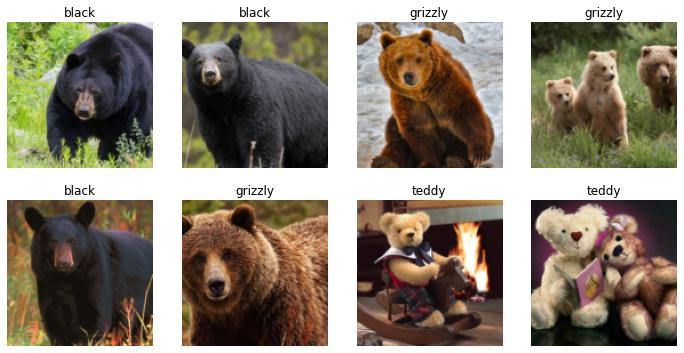

In [16]:
# Checking the images and their labels
dls.valid.show_batch(max_n=8, nrows=2)

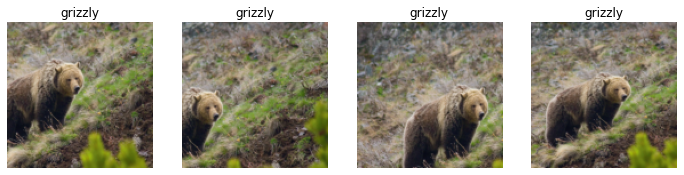

In [17]:
# Randomly select part of and image, and crop to just that part.
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True) #Using unique=True to have the same image repeated with different versions of RandomResizedCrop

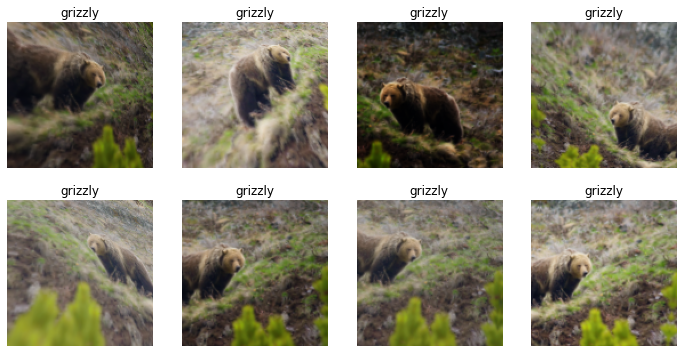

In [18]:
# Creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data.
# Data augmentation
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


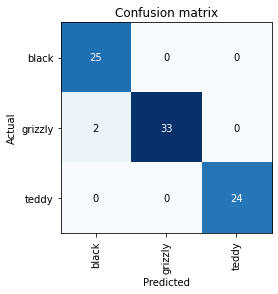

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

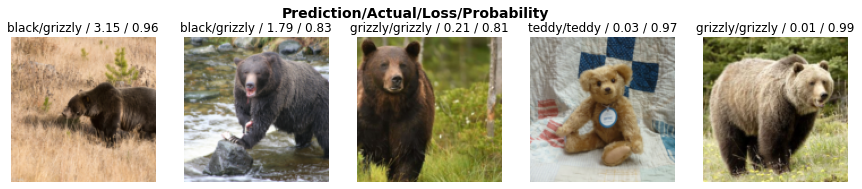

In [21]:
interp.plot_top_losses(5, nrows=1)

In [22]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [23]:
learn.export()

In [24]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [25]:
learn_inf = load_learner(path/'export.pkl')

In [26]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([1.6067e-07, 1.0000e+00, 2.8724e-08]))

In [27]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']